In [1]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


### 1. Exploratory Data Analysis

In [32]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

path = Path("dataset")
img_as_jpg = list(path.glob(r"*/*.bmp"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_as_jpg))
all_ = file_count.count('all')
hem = file_count.count('hem')

In [33]:
train_dataset_0_all=glob.glob('dataset/training/fold_0/all/*.bmp')
train_dataset_0_hem=glob.glob('dataset/training/fold_0/hem/*.bmp')
train_dataset_1_all=glob.glob('dataset/training/fold_1/all/*.bmp')
train_dataset_1_hem=glob.glob('dataset/training/fold_1/hem/*.bmp')
train_dataset_2_all=glob.glob('dataset/training/fold_2/all/*.bmp')
train_dataset_2_hem=glob.glob('dataset/training/fold_2/hem/*.bmp')

In [63]:
test=pd.read_csv('dataset/validation/C-NMC_test_prelim_phase_data_labels.csv')

In [35]:
a,b,c=len(train_dataset_0_all),len(train_dataset_1_all),len(train_dataset_2_all)
d=a+b+c
print('count:',d)

count: 7272


In [36]:
a,b,c=len(train_dataset_0_hem),len(train_dataset_1_hem),len(train_dataset_2_hem)
d=a+b+c
print('count:',d)

count: 3389


In [37]:
A=[]
H=[]
A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)
H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)
print(len(A))
print(len(H))

7272
3389


In [64]:
del test["Patient_ID"]

In [65]:
test["labels"] = ["ALL" if i == 1 else "HEM" for i in test["labels"]]

In [66]:
test.columns = ["image", "labels"]

In [67]:
test['image'] = ["dataset/validation/C-NMC_test_prelim_phase_data/"+i for i in test['image']]

In [68]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1867 non-null   object
 1   labels  1867 non-null   object
dtypes: object(2)
memory usage: 29.3+ KB


In [69]:
test

,image,labels
0,dataset/validation/C-NMC_test_prelim_phase_dat...,ALL
1,dataset/validation/C-NMC_test_prelim_phase_dat...,ALL
2,dataset/validation/C-NMC_test_prelim_phase_dat...,ALL
3,dataset/validation/C-NMC_test_prelim_phase_dat...,HEM
4,dataset/validation/C-NMC_test_prelim_phase_dat...,ALL
...,...,...
1862,dataset/validation/C-NMC_test_prelim_phase_dat...,ALL
1863,dataset/validation/C-NMC_test_prelim_phase_dat...,ALL
1864,dataset/validation/C-NMC_test_prelim_phase_dat...,HEM
1865,dataset/validation/C-NMC_test_prelim_phase_dat...,ALL


In [42]:
training = pd.DataFrame(A, columns=['image'])

In [43]:
training['labels'] = ["ALL" for i in range(len(A))]

In [44]:
training = training.append(pd.DataFrame({'image':H, 'labels':["HEM" for i in range(len(H))]}), ignore_index=True)

In [45]:
A=np.array(A)
H=np.array(H)

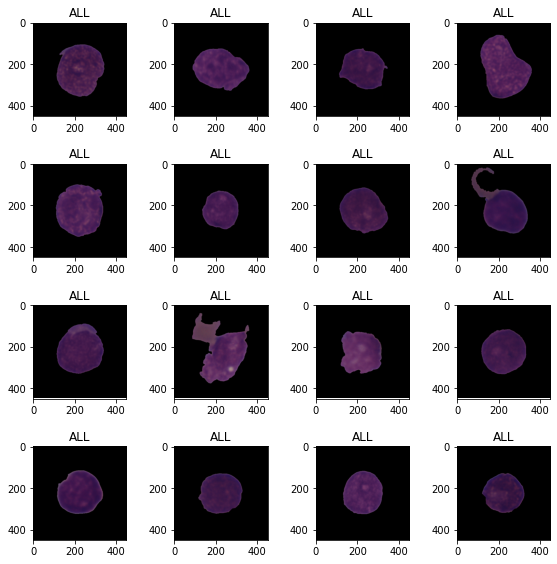

In [46]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1): 
    ax.imshow(plt.imread(training["image"][counter]))
    ax.set_title(training["labels"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

## 2. Model

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

train_ds = train_gen.flow_from_dataframe(
    training,
    x_col="image",
    y_col="labels",
    target_size=(128, 128),
    batch_size=64,
    color_mode="rgb",
    shuffle=True,
    class_mode='binary')

validation_ds = train_gen.flow_from_dataframe(
    test,
    x_col="image",
    y_col="labels",
    target_size=(128, 128),
    batch_size=64,
    color_mode="rgb",
    shuffle=True,
    class_mode='binary')

Found 10661 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.


In [74]:
!nvidia-smi

Tue Jul  6 18:38:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla V1...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Tesla V1...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   

In [78]:
## train_test structure
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=2,
    batch_size=64,
)

 

In [75]:
train_ds

In [79]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.a

In [80]:
model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devi

In [84]:
model.save("models/ViT_on_10_epochs.model")

INFO:tensorflow:Assets written to: models/ViT_on_10_epochs.model/assets


INFO:tensorflow:Assets written to: models/ViT_on_10_epochs.model/assets
